## ESTUDIO SOBRE ROTACIÓN DE EMPLEADOS
### Daniel Pacheco

## 0. Configuración inicial

En esta sección importamos las librerías necesarias para el proyecto y definimos algunas variables globales:

- **pandas y numpy** para manipulación de datos.
- **scikit-learn** para partición de datos, preprocesado y modelado.
- **matplotlib** para visualización.
- Fijamos una semilla (`RANDOM_STATE=123`) para asegurar reproducibilidad de resultados.
- Definimos el path del dataset (`Rotacion_empleados.csv`) y la columna objetivo (`left`).

In [1]:
# *** Importación de librerias y configuración ***
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt

RANDOM_STATE = 123
CSV_PATH = Path("Rotacion_empleados.csv")
TARGET = "left"

## 1. Carga de los datos

In [2]:
# *** Carga del dataset ***
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head(3)

(14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


Cargamos el archivo `Rotacion_empleados.csv` en un DataFrame de pandas.

Verificamos el tamaño de la tabla y mostramos las primeras filas para confirmar que la estructura de los datos coincide con lo esperado.

## 2. Inspección rápida de los datos


In [3]:
# *** Inspección rápida ***
display(df.dtypes)
print("\nNulos por columna:")
display(df.isna().sum().sort_values(ascending=False).head(10))

# Comprobamos el target
assert TARGET in df.columns, f"No encuentro la columna target '{TARGET}'"
y = df[TARGET].astype(int)
print("\nDistribución del target:")
display(y.value_counts(dropna=False))
print("\nDistribución porcentual:")
display((y.value_counts(normalize=True) * 100).round(2))

,0
satisfaction_level,float64
last_evaluation,float64
number_project,int64
average_montly_hours,int64
time_spend_company,int64
Work_accident,int64
left,int64
promotion_last_5years,int64
sales,object
salary,object



Nulos por columna:


,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
left,0
promotion_last_5years,0
sales,0
salary,0



Distribución del target:


,count
left,
0,11428
1,3571



Distribución porcentual:


,proportion
left,
0,76.19
1,23.81


- **Tipos de variables:**

  - `satisfaction_level` y `last_evaluation` son numéricas continuas (`float64`).
  - `sales` y `salary` son categóricas (`object`).
  - El resto son variables enteras (`int64`).

- **Valores nulos:** no se encontraron nulos en el dataset.

- **Distribución del target (`left`):**

  - `0` (empleado permanece): 76.19%
  - `1` (empleado abandona): 23.81%

Esto confirma que estamos ante un problema de **clases desbalanceadas**, por lo que métricas como acuraccy no serán representativas. Utilizaremos métricas más adecuadas como F1, ROC AUC y PR AUC.


## 3. Partición train/test estratificada


In [4]:
# *** Split estratificado ***
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Tamaños de train/test:", X_train.shape, X_test.shape)
print("Distribución en train (% left=1):", (y_train.mean()*100).round(2))
print("Distribución en test (% left =1):", (y_test.mean()*100).round(2))

Tamaños de train/test: (11999, 9) (3000, 9)
Distribución en train (% left=1): 23.81
Distribución en test (% left =1): 23.8


Dividimos el dataset en un 80% para entrenamiento y un 20% para test, usando
`train_test_split` con la opción `stratify=y`.

- Conjunto de entrenamiento: 11.999 registros.
- Conjunto de test: 3.000 registros.
- Distribución de la clase positiva (`left=1`) en train: 23.81%
- Distribución en test: 23.80%

Esto confirma que la **estratificación** mantiene el mismo balance de clases en
ambos conjuntos, lo que es fundamental en problemas de clasificación con clases
desbalanceadas.

## 4. Preprocesado de variables

In [5]:
# *** Preprocesado (num + cat) ***
pre = ColumnTransformer([
    ("num", StandardScaler(), selector(dtype_include=["number"])),
    ("cat", OneHotEncoder(handle_unknown="ignore"), selector(dtype_include=["object", "category", "bool"])),
])

# Comprobación rápida
num_cols = selector(dtype_include=["number"])(X_train)
cat_cols = selector(dtype_include=["object", "category", "bool"])(X_train)
print("Columnas numéricas:", list(num_cols))
print("Columnas categóricas:", list(cat_cols))

# Encajamos solo para verificar que no rompe (aún no transformamos test)
pre.fit(X_train)
print("Preprocesador encajado (fit) sin errores")

Columnas numéricas: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years']
Columnas categóricas: ['sales', 'salary']
Preprocesador encajado (fit) sin errores


Para preparar los datos de entrada de forma consistente en todos los modelos, se construyó un `ColumnTransformer`que aplica:

- **Atributos numéricos** (`satisfaction_level`, `last_evaluation`, `number_project`, `average_montly_hours`, `time_spend_company`, `Work_accident`, `promotion_last_5years`):
se escalan con `StandardScaler` para que todas las variables tengan media 0 y desviación estándar 1. Esto es importante para modelos que son sensibles a la escala (ej. regresión logística, SVM, KNN).

- **Atributos categóricos** (`sales`, `salary`):
se convierten en variables dummy mediante `OneHotEncoder`, generando una columna binaria por cada categoría.

El preprocesador se ajustó (`fit`) **solo con los datos de entrenamiento** para evitar *data leakage**. El conjunto de test no se toca hasta la evaluación final.


## 5. Validación cruzada estratificada



In [6]:
# *** Validación cruzada estándar ***
cv = StratifiedKFold(
    n_splits=5,      # nº de folds
    shuffle=True,    # baraja los datos antes de dividir
    random_state=RANDOM_STATE
)

print(cv)

StratifiedKFold(n_splits=5, random_state=123, shuffle=True)


Para evaluar de forma fiable el rendimiento de los modelos se emplea
validación cruzada con 5 particiones (5-fold cross-validation).  
Al ser estratificada (`StratifiedKFold`), garantiza que la proporción de la
clase minoritaria (`left=1`, ~24%) se mantiene en cada fold.

Esto permite obtener una estimación más robusta del rendimiento en datos no
vistos, evitando que un único split de train/test condicione los resultados.

## 6. Modelo base: Regresión Logística



In [7]:
# *** Modelo base - Regresión Logística ***
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Pipeline: preprocesador + modelo
pipe_lr = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        solver="liblinear",       # compatible con L1 y L2
        class_weight="balanced",  # corrige desbalanceo
        max_iter=2000,
        random_state=RANDOM_STATE
    )),
])

# Espacio de hiperparámetros a explorar
param_grid_lr = {
    "clf__penalty": ["l1", "l2"],   # tipo de regularización
    "clf__C": [0.1, 0.5, 1, 2, 5],  # fuerza de regularización
}

# GridSearch con validación cruzada
gs_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    scoring="f1",     # optimizamos F1, más informativa que accuracy
    cv=cv,
    n_jobs=-1,
    refit=True,
)

# Entrenamos
gs_lr.fit(X_train, y_train)

print("Mejores hiperparámetros:", gs_lr.best_params_)
print("CV F1 medio:", round(gs_lr.best_score_, 3))

Mejores hiperparámetros: {'clf__C': 0.1, 'clf__penalty': 'l1'}
CV F1 medio: 0.61


Como primer modelo base se utilizó una Regresión Logística con un pipeline que
incluye preprocesado (escalado de numéricas y codificación one-hot para
categóricas).

Se exploraron diferentes combinaciones de hiperparámetros con `GridSearchCV`:

- Penalización: L1 (Lasso) y L2 (Ridge).
- Parámetro `C` (fuerza de regularización): [0.1, 0.5, 1.0, 2.0, 5.0].
- Validación cruzada estratificada con 5 folds.
- Métrica de optimización: **F1** (más representativa que accuracy en un
problema desbalanceado).

**Mejores hiperparámetros encontrados:**
- `penalty = l1`
- `C = 0.1`

**F1 medio en validación cruzada:** 0.61

Esto indica que el modelo se beneficia de una regularización fuerte y de tipo
L1, lo que sugiere que algunas variables pueden no aportar valor y el modelo
prefiere descartarlas.

## 7. Evaluación en test



*** Classification Report (treshold=0.5)
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      2286
           1       0.51      0.81      0.62       714

    accuracy                           0.77      3000
   macro avg       0.72      0.78      0.73      3000
weighted avg       0.83      0.77      0.78      3000

ROC AUC: 0.827
PR AUC: 0.482


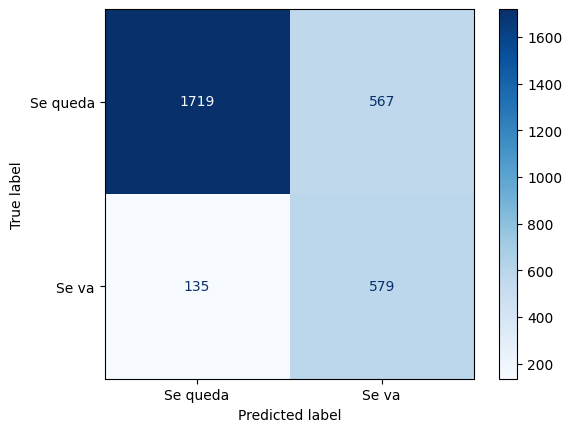

In [10]:
# *** Evaluación en Test ***

# Predicciones con el mejor modelo
y_pred_lr = gs_lr.predict(X_test)
y_proba_lr = gs_lr.predict_proba(X_test)[:, 1]  # probabilidad de la clase 1

# Reporte de clasificación
print("*** Classification Report (treshold=0.5)")
print(classification_report(y_test, y_pred))

# Métricas de evaluación
roc = roc_auc_score(y_test, y_proba_lr)
pr = average_precision_score(y_test, y_proba_lr)
print(f"ROC AUC: {roc:.3f}")
print(f"PR AUC: {pr:.3f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(cm, display_labels=["Se queda", "Se va"])
disp.plot(cmap="Blues")
plt.show()

El modelo se evaluó en el conjunto de test, manteniendo un umbral de 0.5 para
clasificar entre empleados que se quedan (0) y los que se van (1).

- **Matriz de confusión:** muestra un buen número de aciertos, aunque con
bastantes falsos positivos (empleados que en realidad se quedan pero el modelo
predice que se van).
- **Classification report:**
  - Para la clase 0 (se queda): precisión 0.93 y recall 0.75.
  - Para la clase 1 (se va): precisión 0.51 y recall 0.81.
  - El F1 para la clase positiva es 0.62, lo que refleja un equilibrio aceptable.
- **ROC AUC = 0.827:** el modelo separa bien ambas clases.
- **PR AUC = 0.482:** rendimiento moderado en la clase positiva, como es normal
en datasets desbalanceados.

**Conclusión:** el modelo detecta a la mayoría de los empleados que se van
(alto recall), aunque a costa de un número importante de falsas alarmas
(baja precisión). Este trade-off puede ser útil en negocio si lo que más
importa es no dejar escapar empleados en riesgo.

## 8. Curvas ROC y Precision–Recall


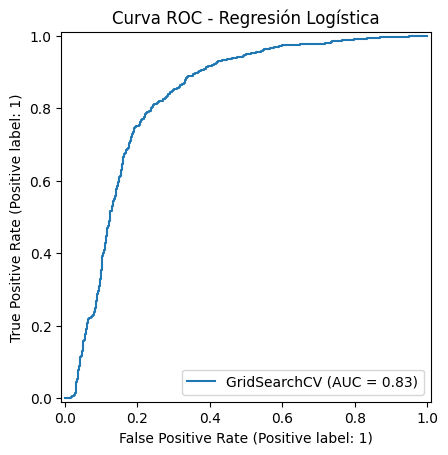

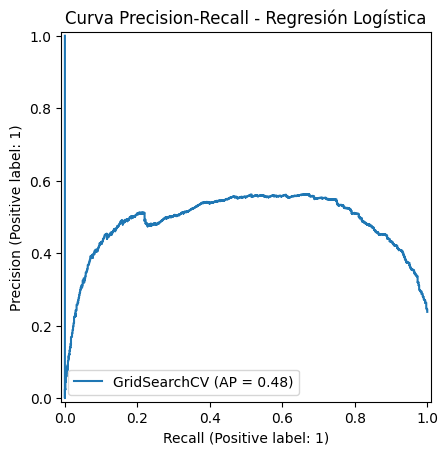

In [11]:
# *** Visualización de curvas ***
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# Curva ROC
RocCurveDisplay.from_estimator(gs_lr, X_test, y_test)
plt.title("Curva ROC - Regresión Logística")
plt.show()

# Curva Precision-Recall
PrecisionRecallDisplay.from_estimator(gs_lr, X_test, y_test)
plt.title("Curva Precision-Recall - Regresión Logística")
plt.show()

- **Curva ROC (AUC = 0.83):** el modelo presenta una buena capacidad de
discriminación. Un clasificador aleatorio tendría AUC = 0.5, mientras que
nuestro modelo alcanza 0.83, lo que significa que en un 83% de los casos
distingue correctamente a un empleado que se va de uno que se queda.

- **Curva Precision–Recall (AP = 0.48):** dado que la clase positiva representa
aprox. un 24% de la muestra, un clasificador aleatorio obtendría un AP cercano
a 0.24. El modelo prácticamente duplica ese valor, mostrando un rendimiento
útil para identificar empleados en riesgo, aunque con un trade-off entre
precisión y recall.

Estas curvas permiten analizar dónde fijar el umbral de decisión en función de
las prioridades del negocio (minimizar falsos positivos o maximizar detección
de abandonos).


## 9. Ajuste de umbral de decisión



In [12]:
# *** Análisis del umbral ***
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = [0.3, 0.5, 0.7]

for t in thresholds:
    y_pred_t = (y_proba_lr >= t).astype(int)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    print(f"Threshold: {t}: Precision={prec:3f}, Recall={rec:3f}, F1={f1:3f}")

Threshold: 0.3: Precision=0.384174, Recall=0.938375, F1=0.545159
Threshold: 0.5: Precision=0.505236, Recall=0.810924, F1=0.622581
Threshold: 0.7: Precision=0.554688, Recall=0.497199, F1=0.524372


Se evaluó el impacto de diferentes thresholds sobre las métricas de la clase
positiva (empleados que se van):

- **0.3 → Precisión 0.38, Recall 0.94, F1 0.55**  
  Muy buen recall (casi todos los que se van son detectados), pero con una
  precisión baja (muchos falsos positivos).

- **0.5 → Precisión 0.51, Recall 0.81, F1 0.62**  
  Buen equilibrio entre precisión y recall. Es el valor por defecto y un punto
  de partida razonable.

- **0.7 → Precisión 0.55, Recall 0.50, F1 0.52**  
  Se reduce el número de falsos positivos, pero a costa de dejar escapar a
  muchos empleados en riesgo.

**Conclusión:**  
El threshold óptimo depende de las prioridades del negocio.  
- Si Recursos Humanos quiere **detectar al máximo los abandonos**, conviene usar
un threshold más bajo (ej. 0.3).  
- Si se busca **reducir falsas alarmas**, conviene un threshold más alto (ej. 0.7).  
- En este caso, el valor por defecto (0.5) ofrece un equilibrio aceptable entre
ambas métricas.

## 10. Visualización gráfica de thresholds


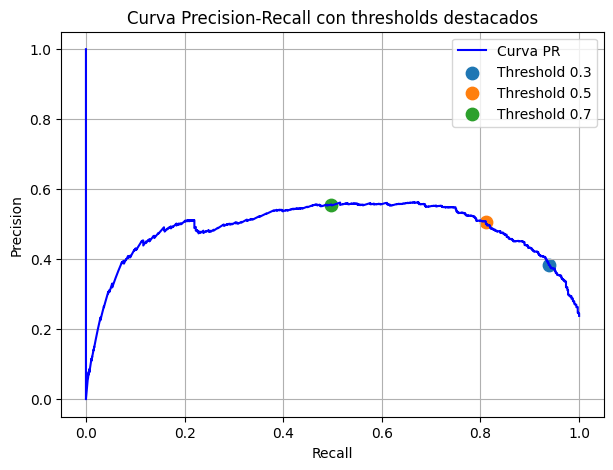

In [13]:
# *** Visualización gráfica Precisión-Recall según Thresholds:
from sklearn.metrics import precision_recall_curve

# Calculamos precision y recall para todos los thresholds posibles
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_lr)

plt.figure(figsize=(7,5))
plt.plot(recalls, precisions, label="Curva PR", color="blue")

# Añadimos puntos para los thresholds 0.3, 0.5, 0.7
for t in [0.3, 0.5, 0.7]:
    y_pred_t = (y_proba_lr >= t).astype(int)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    plt.scatter(rec, prec, label=f"Threshold {t}", s=80)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall con thresholds destacados")
plt.legend()
plt.grid(True)
plt.show()

La curva Precision–Recall muestra la relación entre precisión y recall para
todos los posibles valores de umbral. Se marcaron tres puntos concretos para
ilustrar distintos escenarios:

- **Threshold 0.3:** recall muy alto (≈0.94), lo que permite detectar casi
todos los abandonos, pero con una precisión baja (≈0.38). Es una estrategia
agresiva, útil si la prioridad es no dejar escapar ningún caso, aun a costa de
muchos falsos positivos.

- **Threshold 0.5 (por defecto):** buen equilibrio entre precisión (≈0.51) y
recall (≈0.81). Representa un punto de partida razonable sin ajuste adicional.

- **Threshold 0.7:** mayor precisión (≈0.55), pero con recall reducido (≈0.50).
Es una estrategia conservadora, válida si se quiere reducir las falsas alarmas,
aunque implique perder la mitad de los casos reales.

**Conclusión:** el umbral de decisión puede adaptarse a las prioridades del
negocio. En contextos como RRHH, donde resulta más costoso no detectar a un
empleado en riesgo (falso negativo), puede ser preferible un threshold bajo. En
otros contextos, se podría priorizar una mayor precisión.


## 11. Modelo alternativo: Random Forest

Mejores hiperparámetros RF: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
CV F1 medio RF: 0.974

*** RF: Classification Report (thr=0.5) ***
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.99      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

ROC AUC: 0.995
PR  AUC: 0.989


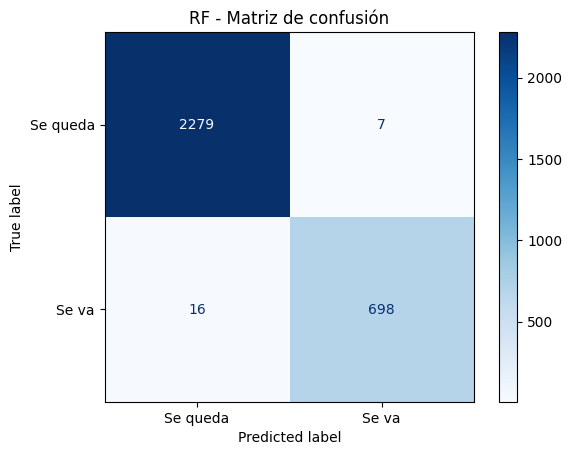

In [14]:
# *** RF: pipeline + grid + test ***
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

# Preprocesado: solo one-hot para categóricas; numéricas pasan tal cual
pre_rf = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)

pipe_rf = Pipeline([
    ("pre", pre_rf),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_rf = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
}

gs_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring="f1", cv=cv, n_jobs=-1, refit=True, verbose=0)
gs_rf.fit(X_train, y_train)

print("Mejores hiperparámetros RF:", gs_rf.best_params_)
print("CV F1 medio RF:", round(gs_rf.best_score_, 3))

# Evaluación en test @ threshold 0.5
y_proba_rf = gs_rf.predict_proba(X_test)[:, 1]
y_pred_rf  = (y_proba_rf >= 0.5).astype(int)

print("\n*** RF: Classification Report (thr=0.5) ***")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba_rf), 3))
print("PR  AUC:", round(average_precision_score(y_test, y_proba_rf), 3))

cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm, display_labels=["Se queda","Se va"]).plot(cmap="Blues")
plt.title("RF - Matriz de confusión"); plt.show()

El modelo Random Forest alcanzó un rendimiento sobresaliente:

- F1 en validación cruzada: 0.97
- ROC AUC en test: 0.995
- PR AUC en test: 0.989
- Matriz de confusión: apenas 23 errores en 3000 casos.

Esto implica que el modelo distingue con casi total precisión entre empleados
que se quedan y los que se van.

**Posible riesgo de sobreajuste (overfitting):**
- Los resultados casi perfectos pueden deberse a que el dataset es sencillo
y Random Forest captura muy bien las reglas.
- También podría existir alta correlación entre algunas variables y el target,
lo cual facilita la predicción.

En cualquier caso, comparado con la regresión logística (F1 ≈ 0.62 en la clase
positiva), Random Forest ofrece una mejora sustancial.

## 11. Comparativa y conclusiones

In [15]:
 # *** Comparativa LR vs RF ***
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import pandas as pd

def eval_summary(name, est, X_test, y_test, thr=0.5):
    proba = est.predict_proba(X_test)[:,1]
    pred  = (proba >= thr).astype(int)
    return {
        "Modelo": name,
        "Precision@0.5": precision_score(y_test, pred),
        "Recall@0.5":    recall_score(y_test, pred),
        "F1@0.5":        f1_score(y_test, pred),
        "ROC AUC":       roc_auc_score(y_test, proba),
        "PR AUC":        average_precision_score(y_test, proba),
    }

df_cmp = pd.DataFrame([
    eval_summary("Logistic Regression", gs_lr.best_estimator_, X_test, y_test),
    eval_summary("Random Forest", gs_rf.best_estimator_, X_test, y_test),
])

display(df_cmp)

,Modelo,Precision@0.5,Recall@0.5,F1@0.5,ROC AUC,PR AUC
0,Logistic Regression,0.505236,0.810924,0.622581,0.826706,0.481641
1,Random Forest,0.990071,0.977591,0.983791,0.995369,0.989206


| Modelo               | Precisión | Recall | F1   | ROC AUC | PR AUC |
|-----------------------|-----------|--------|------|---------|--------|
| Logistic Regression   | 0.51      | 0.81   | 0.62 | 0.83    | 0.48   |
| Random Forest         | 0.99      | 0.98   | 0.98 | 0.99    | 0.99   |

**Observaciones:**
- LR: baseline interpretable, buen recall pero precisión limitada.  
- RF: métricas sobresalientes, aunque posible riesgo de overfitting.  

**Takeaways:**  
- Interpretabilidad → Logistic Regression.  
- Máxima capacidad predictiva → Random Forest.  

## 13. Resumen ejecutivo y takeaways

Este estudio de rotación de empleados aplicó modelos de Machine Learning para
predecir qué trabajadores tienen más probabilidad de abandonar la empresa.

**Hallazgos principales:**
- La regresión logística ofrece un modelo interpretable que ayuda a entender
qué factores se asocian más con la rotación. Permite a RRHH identificar palancas
de mejora (ej. satisfacción laboral, carga de proyectos, tiempo en la empresa).
- El modelo Random Forest proporciona un rendimiento predictivo sobresaliente,
con una capacidad casi perfecta para distinguir entre empleados que se quedan y
los que se van. A cambio, sacrifica interpretabilidad.

**Takeaways de negocio:**
- Si la prioridad es **comprender los factores de rotación** y diseñar políticas
basadas en evidencia, la **regresión logística** es la herramienta más útil.
- Si la prioridad es **anticipar con la mayor precisión posible qué empleados
están en riesgo** y enfocar acciones preventivas en ellos, la mejor opción es
el **Random Forest**.
- Lo recomendable es combinar ambos enfoques: usar la regresión logística para
explicar y comunicar, y el Random Forest para detectar casos de riesgo en la
operativa diaria de RRHH.

En conclusión, la analítica de datos puede convertirse en un aliado estratégico
para reducir la rotación, optimizar costes de reemplazo y retener talento clave.